In [1]:
import pandas as pd 
from datetime import datetime, timedelta

# Install PRAW if not already installed
!pip install praw

import praw

# Connect to Reddit (replace with your credentials)
reddit = praw.Reddit(
    client_id="yrAGhMS2xOXBk98FOsNXhA", 
    client_secret="2OsdUGswXKHMImthSz1abEzzKeKExw", 
    user_agent="web:myredditapp:1.0.0(by/u/Linglaoyao)"
)

# Quick test: fetch top 5 posts from r/python
for submission in reddit.subreddit("python").hot(limit=5):
    print(submission.title)


  Using cached praw-7.8.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached prawcore-2.4.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached update_checker-0.18.0-py3-none-any.whl.metadata (2.3 kB)
Using cached praw-7.8.1-py3-none-any.whl (189 kB)
Using cached prawcore-2.4.0-py3-none-any.whl (17 kB)
Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [praw]
Sunday Daily Thread: What's everyone working on this week?
Tuesday Daily Thread: Advanced questions
Zuban is now Open Source
PyLine Update - terminal based text editor (Linux, WSL, MacOS) (New Feats)
Meet THOAD, High Order Derivatives for PyTorch Graphs


In [2]:
print('Reddit API Connection : ', reddit.read_only)

Reddit API Connection :  True


In [3]:
def scrape_subreddit(reddit, subreddit_name, start_date, end_date, post_limit=1000):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    
    for post in subreddit.new(limit=post_limit):
        post_date = datetime.fromtimestamp(post.created_utc)
        if start_date <= post_date <= end_date:
            posts.append({
                'title' : post.title,
                'id' : post.id,
                'author' : str(post.author),
                'created_utc' : post_date,
                'score' : post.score,
                'upvote_ratio' : post.upvote_ratio,
                'num_comments' : post.num_comments,
                'url' : post.url,
                'selftext' : post.selftext
            })
            
    return pd.DataFrame(posts)

In [4]:
def scrape_multiple_subreddits(subreddits, months=6, post_limit=1000):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30 * months)
    combined_data = pd.DataFrame()
    
    for subreddit in subreddits: 
        print(f'Scraping subreddit : {subreddit} from {start_date} to {end_date}')
        subreddit_data = scrape_subreddit(
            reddit, subreddit, start_date, end_date, post_limit=post_limit
        )
        combined_data = pd.concat([combined_data, subreddit_data], ignore_index=True)
    return combined_data

In [5]:
subreddits_to_scrape = ['stocks', 'investing', 'wallstreetbets']
months_to_scrape = 6
max_posts_per_subreddit = 1000

scraped_data = scrape_multiple_subreddits(
    subreddits = subreddits_to_scrape,
    months = months_to_scrape,
    post_limit = max_posts_per_subreddit
)

Scraping subreddit : stocks from 2025-03-07 14:34:21.515688 to 2025-09-03 14:34:21.515688
Scraping subreddit : investing from 2025-03-07 14:34:21.515688 to 2025-09-03 14:34:21.515688
Scraping subreddit : wallstreetbets from 2025-03-07 14:34:21.515688 to 2025-09-03 14:34:21.515688


In [6]:
output_file = 'reddit_stock_data.csv'
scraped_data.to_csv(output_file, index=False)
print(f'Scraped data saved to {output_file}')

Scraped data saved to reddit_stock_data.csv


In [7]:
print(f'Total posts scraped : {len(scraped_data)}')

Total posts scraped : 2661


In [8]:
# Install vaderSentiment
!pip install vaderSentiment

# Import and quick test
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Example text
sample_text = "The stock market is doing great today!"
print(analyzer.polarity_scores(sample_text))


  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.6588}


In [9]:
input_file = 'reddit_stock_data.csv'
scraped_data = pd.read_csv(input_file)

In [10]:
scraped_data['created_utc'] = pd.to_datetime(scraped_data['created_utc'])

In [11]:
scraped_data['date_only'] = scraped_data['created_utc'].dt.date

In [12]:
analyzer = SentimentIntensityAnalyzer()

In [13]:
def analyze_sentiment(text):
    if pd.isna(text):
        text = ''
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

In [14]:
scraped_data['sentiment'] = scraped_data['selftext'].apply(analyze_sentiment)

In [15]:
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [16]:
scraped_data['sentiment_label'] = scraped_data['sentiment'].apply(classify_sentiment)

In [17]:
def extract_tickers(text):
    if pd.isna(text):
        return []
    return re.findall(r'\b[A-Z]{2,5}\b', text)

In [18]:
scraped_data['tickers'] = scraped_data['selftext'].apply(extract_tickers)

In [19]:
output_file = 'analyzed_stock_data.csv'
scraped_data.to_csv(output_file, index=False)
print(f'Prepared data saved to {output_file}')

Prepared data saved to analyzed_stock_data.csv


In [20]:
# Install yfinance
!pip install yfinance

# Import and quick test
import yfinance as yf

# Example: download last 5 days of Apple stock prices
df = yf.download("AAPL", period="5d")
print(df)



/tmp/ipykernel_966/992222573.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", period="5d")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-08-27  230.490005  230.899994  228.259995  228.610001  31259500
2025-08-28  232.559998  233.410004  229.339996  230.820007  38074700
2025-08-29  232.139999  233.380005  231.369995  232.509995  39418400
2025-09-02  229.720001  230.850006  226.970001  229.250000  43804400
2025-09-03  237.149994  237.970001  234.369995  237.199997  22136411


In [21]:
reddit_file = 'analyzed_stock_data.csv'
reddit_data = pd.read_csv(reddit_file)

In [22]:
reddit_data['date_only'] = pd.to_datetime(reddit_data['date_only'])

In [23]:
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = []
    for ticker in tickers:
        try:
            print(f"Fetching data for {ticker}...")
            data = yf.download(ticker, start=start_date, end=end_date)
            if not data.empty:
                data['ticker'] = ticker
                
                data['date_only_'] = data.index.date
                
                data.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in data.columns]
                
                data.rename(columns={col: 'date_only' if 'date_only' in col else col for col in data.columns}, inplace=True)
                print(f"Date_only column added for {ticker}. Columns: {data.columns}")
                stock_data.append(data)
            else:
                print(f"No data found for {ticker}.")
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    
    
    if stock_data:
        combined_data = pd.concat(stock_data, ignore_index=True)
        print(f"Combined stock data columns: {combined_data.columns}")
    else:
        combined_data = pd.DataFrame()  
        print("No stock data fetched.")

    
    if 'date_only' in combined_data.columns:
        combined_data['date_only'] = pd.to_datetime(combined_data['date_only'])
    else:
        print("Warning: 'date_only' column not found in combined stock data.")

    return combined_data

In [24]:
tickers = ['SYM', 'PLTR', 'NVDA', 'VOO', 'AMBA']
start_date = (datetime.now() - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

combined_stock_data = fetch_stock_data(tickers, start_date, end_date)

if 'date_only' in combined_stock_data.columns:
    print("date_only column found in stock data!")
else:
    print("date_only column not found in stock data.")


combined_stock_data = combined_stock_data.reset_index(drop=True)
reddit_data = reddit_data.reset_index(drop=True)

/tmp/ipykernel_966/3373024186.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)


Fetching data for SYM...


[*********************100%***********************]  1 of 1 completed

Date_only column added for SYM. Columns: Index(['Close_SYM', 'High_SYM', 'Low_SYM', 'Open_SYM', 'Volume_SYM', 'ticker_',
       'date_only'],
      dtype='object')
Fetching data for PLTR...



/tmp/ipykernel_966/3373024186.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_966/3373024186.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)


Date_only column added for PLTR. Columns: Index(['Close_PLTR', 'High_PLTR', 'Low_PLTR', 'Open_PLTR', 'Volume_PLTR',
       'ticker_', 'date_only'],
      dtype='object')
Fetching data for NVDA...


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_966/3373024186.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)


Date_only column added for NVDA. Columns: Index(['Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA',
       'ticker_', 'date_only'],
      dtype='object')
Fetching data for VOO...


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_966/3373024186.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Date_only column added for VOO. Columns: Index(['Close_VOO', 'High_VOO', 'Low_VOO', 'Open_VOO', 'Volume_VOO', 'ticker_',
       'date_only'],
      dtype='object')
Fetching data for AMBA...
Date_only column added for AMBA. Columns: Index(['Close_AMBA', 'High_AMBA', 'Low_AMBA', 'Open_AMBA', 'Volume_AMBA',
       'ticker_', 'date_only'],
      dtype='object')
Combined stock data columns: Index(['Close_SYM', 'High_SYM', 'Low_SYM', 'Open_SYM', 'Volume_SYM', 'ticker_',
       'date_only', 'Close_PLTR', 'High_PLTR', 'Low_PLTR', 'Open_PLTR',
       'Volume_PLTR', 'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA',
       'Volume_NVDA', 'Close_VOO', 'High_VOO', 'Low_VOO', 'Open_VOO',
       'Volume_VOO', 'Close_AMBA', 'High_AMBA', 'Low_AMBA', 'Open_AMBA',
       'Volume_AMBA'],
      dtype='object')
date_only column found in stock data!


In [25]:
merged_data = pd.merge(
    reddit_data, combined_stock_data, on='date_only', how='inner'
)
print('Merge Successful')

Merge Successful


In [26]:
merged_data.drop(columns=['date_only', 'created_utc'], inplace=True)

In [27]:
output_file = 'stock_sentiment_combined_data.csv'
merged_data.to_csv(output_file, index=False)
print(f'Stock Sentiment Data saved to {output_file}')

Stock Sentiment Data saved to stock_sentiment_combined_data.csv


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import joblib

In [29]:
data = pd.read_csv('stock_sentiment_combined_data.csv')

In [30]:
columns_to_drop = ['title', 'id', 'author', 'score', 'upvote_ratio', 'num_comments', 'url', 'selftext', 'sentiment', 'sentiment_label', 'tickers', 'ticker_']
data = data.drop(columns=columns_to_drop, errors='ignore')

In [31]:
print('Shape of data after dropping irrelevant columns : ', data.shape)

Shape of data after dropping irrelevant columns :  (10655, 25)


In [32]:
data.fillna(data.mean(), inplace=True)
print('Remaining missing values per column :\n',data.isnull().sum())

Remaining missing values per column :
 Close_SYM      0
High_SYM       0
Low_SYM        0
Open_SYM       0
Volume_SYM     0
Close_PLTR     0
High_PLTR      0
Low_PLTR       0
Open_PLTR      0
Volume_PLTR    0
Close_NVDA     0
High_NVDA      0
Low_NVDA       0
Open_NVDA      0
Volume_NVDA    0
Close_VOO      0
High_VOO       0
Low_VOO        0
Open_VOO       0
Volume_VOO     0
Close_AMBA     0
High_AMBA      0
Low_AMBA       0
Open_AMBA      0
Volume_AMBA    0
dtype: int64


In [33]:
print('Columns in the dataset : ',data.columns)

Columns in the dataset :  Index(['Close_SYM', 'High_SYM', 'Low_SYM', 'Open_SYM', 'Volume_SYM',
       'Close_PLTR', 'High_PLTR', 'Low_PLTR', 'Open_PLTR', 'Volume_PLTR',
       'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA',
       'Close_VOO', 'High_VOO', 'Low_VOO', 'Open_VOO', 'Volume_VOO',
       'Close_AMBA', 'High_AMBA', 'Low_AMBA', 'Open_AMBA', 'Volume_AMBA'],
      dtype='object')


In [34]:
data['Movement'] = data.apply(lambda row: 'up' if row['Close_NVDA'] > row['Open_NVDA'] else 'down', axis=1)

In [35]:
features = ['Close_SYM', 'High_SYM', 'Low_SYM', 'Open_SYM', 'Volume_SYM',
            'Close_PLTR', 'High_PLTR', 'Low_PLTR', 'Open_PLTR', 'Volume_PLTR',
            'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA',
            'Close_VOO', 'High_VOO', 'Low_VOO', 'Open_VOO', 'Volume_VOO',
            'Close_AMBA', 'High_AMBA', 'Low_AMBA', 'Open_AMBA', 'Volume_AMBA']

In [36]:
missing_columns = [col for col in features if col not in data.columns]
if missing_columns:
    print(f'Missing required columns : {missing_columns}')
    exit()

X = data[features]
y = data['Movement']

In [37]:
print('Shape of features (X) :',X.shape)
print('Shape of target (y) : ',y.shape)

Shape of features (X) : (10655, 25)
Shape of target (y) :  (10655,)


In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [40]:
param_grid = {
    'n_estimators' : [100,150,200],
    'max_depth' : [10,15,20],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid_search.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 15, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 150, ...]}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [41]:
best_model = grid_search.best_estimator_
print('Best Hyperparameters : ', grid_search.best_params_)

Best Hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [42]:
y_pred = best_model.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='up')
recall = recall_score(y_test, y_pred, pos_label='up')

In [44]:
print('Model Performance')
print(f'Accuracy : {accuracy}')
print(f'Precision : {precision}')
print(f'Recall : {recall}')

Model Performance
Accuracy : 1.0
Precision : 1.0
Recall : 1.0


In [45]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

        down       1.00      1.00      1.00       189
          up       1.00      1.00      1.00      1942

    accuracy                           1.00      2131
   macro avg       1.00      1.00      1.00      2131
weighted avg       1.00      1.00      1.00      2131



In [46]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[ 189    0]
 [   0 1942]]


In [47]:
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='accuracy')
print('Cross-Validated Accuracy : ',cv_scores.mean())

Cross-Validated Accuracy :  0.9960581886438291


In [48]:
joblib.dump(best_model, 'stock_movement_classifier.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Model and Scaler have been saved in the Models Folder')

Model and Scaler have been saved in the Models Folder


In [49]:
# ===== Reddit Sentiment Backtest (5 years) =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ast
from pathlib import Path

In [50]:
# -----------------------------
# 1) Load Reddit sentiment data and build daily signals per ticker
# -----------------------------
reddit_file = "analyzed_stock_data.csv"   # produced earlier by your pipeline
reddit = pd.read_csv(reddit_file)

# Parse dates and the 'tickers' list column safely
reddit["date_only"] = pd.to_datetime(reddit["date_only"])
if "tickers" in reddit.columns:
    reddit["tickers"] = reddit["tickers"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else (x if isinstance(x, list) else [])
    )
else:
    reddit["tickers"] = [[] for _ in range(len(reddit))]

# explode to (date, ticker) rows and aggregate the sentiment by day/ticker
sig_df = (
    reddit.explode("tickers")
          .dropna(subset=["tickers"])
          .groupby(["date_only", "tickers"], as_index=False)["sentiment"]
          .mean()
          .rename(columns={"tickers": "ticker"})
)

In [51]:
# -----------------------------
# 2) Choose your universe & fetch 2y prices
# -----------------------------
# Edit this list to your current selections; we'll compare each to SPY and also a basket.
selected_tickers = ["PLTR", "NVDA", "AAPL", "AMBA", "SYM", "TSLA"]  # adjust as you like
benchmark = "SPY"

end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=2)

px = yf.download(selected_tickers + [benchmark], start=start.date(), end=end.date())["Close"]
px = px.dropna(how="all")  # drop days with no data at all
px.index.name = "date_only"

# Align signals to price calendar; pivot to wide [dates x tickers]
signals_wide = (
    sig_df.pivot(index="date_only", columns="ticker", values="sentiment")
          .reindex(px.index)
          .fillna(0.0)  # no posts = neutral (0)
)

# Keep only signals for tickers we have prices for
signals_wide = signals_wide.reindex(columns=[c for c in selected_tickers if c in px.columns]).fillna(0.0)

# If any selected ticker isn’t in prices, warn
missing_px = [t for t in selected_tickers if t not in px.columns]
if missing_px:
    print(f"Warning: Missing price history for: {missing_px}. They will be dropped from the backtest.")
selected_tickers = [t for t in selected_tickers if t in px.columns]

/tmp/ipykernel_966/548050378.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(selected_tickers + [benchmark], start=start.date(), end=end.date())["Close"]
[*********************100%***********************]  7 of 7 completed


In [52]:
# -----------------------------
# 3) Build positions from rules (applied next day to avoid lookahead)
# -----------------------------
ENTRY = 0.05
EXIT  = -0.05
COST  = 0.000  # 0.0%
TRADING_DAYS = 252

# Desired raw long signal today based on yesterday’s sentiment
# Long if sentiment > 0.05; Flat if sentiment < -0.05; Neutral (between) → 0 (flat) for this 1-day holding rule
raw_long = (signals_wide > ENTRY).astype(int)
raw_flat = (signals_wide < EXIT).astype(int)

# Convert to desired positions for *tomorrow*: if long signal yesterday → 1 tomorrow; if exit yesterday → 0 tomorrow
desired_pos = (raw_long.shift(1).fillna(0) * 1)  # 1 where long signal yesterday
# Explicit exits force 0 tomorrow
desired_pos = desired_pos.mask(raw_flat.shift(1) == 1, 0).fillna(0).astype(int)

# Equal-weight across active names each day
weights = desired_pos.div(desired_pos.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

In [53]:
# -----------------------------
# 4) Compute returns and apply transaction costs
# -----------------------------
rets = px[selected_tickers].pct_change().fillna(0.0)
spy_rets = px[benchmark].pct_change().fillna(0.0)

# Gross portfolio daily return (use today's weights on today's returns is fine since we used shift for signal)
gross_ret = (weights * rets).sum(axis=1)

# Turnover = sum |w_t - w_{t-1}| / 2 (the /2 is optional; here we use full L1 change)
turnover = (weights.diff().abs().sum(axis=1)).fillna(0.0)

# Transaction cost impact
cost_impact = COST * turnover
net_ret = gross_ret - cost_impact

In [54]:
# -----------------------------
# 5) Per-stock single-name strategies (for comparison vs SPY)
# -----------------------------
per_stock_results = {}
for t in selected_tickers:
    pos_t = desired_pos[[t]].rename(columns={t: "pos"})
    w_t = pos_t["pos"]  # 0/1
    r_t = rets[t]

    # Turnover for single name (abs change in position)
    to_t = w_t.diff().abs().fillna(0.0)
    ret_gross_t = w_t.shift(0) * r_t  # we already shifted signals by one day when building desired_pos
    ret_net_t = ret_gross_t - COST * to_t

    per_stock_results[t] = {
        "gross": ret_gross_t.fillna(0.0),
        "net":   ret_net_t.fillna(0.0),
    }

In [55]:
# -----------------------------
# 6) Performance metrics helpers
# -----------------------------
def perf_metrics(returns: pd.Series, benchmark_returns: pd.Series | None = None, trading_days: int = TRADING_DAYS):
    returns = returns.dropna()
    if len(returns) == 0:
        return {}

    equity = (1 + returns).cumprod()
    cum_return = equity.iloc[-1] - 1
    ann_return = returns.mean() * trading_days
    ann_vol = returns.std(ddof=0) * np.sqrt(trading_days)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    # Max drawdown
    rolling_max = equity.cummax()
    drawdown = equity / rolling_max - 1
    max_dd = drawdown.min()

    # Sortino
    downside = returns.where(returns < 0, 0)
    downside_vol = downside.std(ddof=0) * np.sqrt(trading_days)
    sortino = ann_return / downside_vol if downside_vol > 0 else np.nan

    out = {
        "Cumulative Return": cum_return,
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe (rf=0)": sharpe,
        "Sortino (rf=0)": sortino,
        "Max Drawdown": max_dd,
    }

    if benchmark_returns is not None:
        # Information ratio & alpha-like comparison
        te = (returns - benchmark_returns.reindex_like(returns)).std(ddof=0) * np.sqrt(trading_days)
        info_ratio = ((ann_return - benchmark_returns.mean() * trading_days) / te) if te > 0 else np.nan
        out["Information Ratio vs SPY"] = info_ratio
        out["Excess Ann Return vs SPY"] = ann_return - benchmark_returns.mean() * trading_days

    return out

In [56]:
# -----------------------------
# 7) Compute metrics and save tables
# -----------------------------
portfolio_metrics = perf_metrics(net_ret, spy_rets)

rows = []
for t, d in per_stock_results.items():
    m = perf_metrics(d["net"], spy_rets)
    m["Name"] = t
    rows.append(m)
per_stock_table = pd.DataFrame(rows).set_index("Name").sort_index()

# Add portfolio row on top
metrics_table = pd.concat(
    [pd.DataFrame({"Name": ["Portfolio"], **{k: [v] for k, v in portfolio_metrics.items()}}).set_index("Name"),
     per_stock_table]
)

# Save to CSV in your top-level workspace
metrics_table.to_csv("backtest_metrics_summary.csv")
net_ret.to_frame("Portfolio_Net_Return").to_csv("backtest_portfolio_daily_returns.csv")
spy_rets.to_frame("SPY_Return").to_csv("backtest_spy_daily_returns.csv")

print("==== Performance Summary (saved to backtest_metrics_summary.csv) ====")
print(metrics_table.round(4))


==== Performance Summary (saved to backtest_metrics_summary.csv) ====
           Cumulative Return  Annualized Return  Annualized Volatility  \
Name                                                                     
Portfolio             0.0260             0.0154                 0.0704   
AAPL                  0.0384             0.0196                 0.0344   
AMBA                  0.0000             0.0000                 0.0000   
NVDA                 -0.0425            -0.0203                 0.0554   
PLTR                 -0.1010            -0.0501                 0.0828   
SYM                  -0.0475            -0.0226                 0.0607   
TSLA                  0.0118             0.0078                 0.0629   

           Sharpe (rf=0)  Sortino (rf=0)  Max Drawdown  \
Name                                                     
Portfolio         0.2192          0.3208       -0.0721   
AAPL              0.5699          1.8900       -0.0122   
AMBA                 NaN       

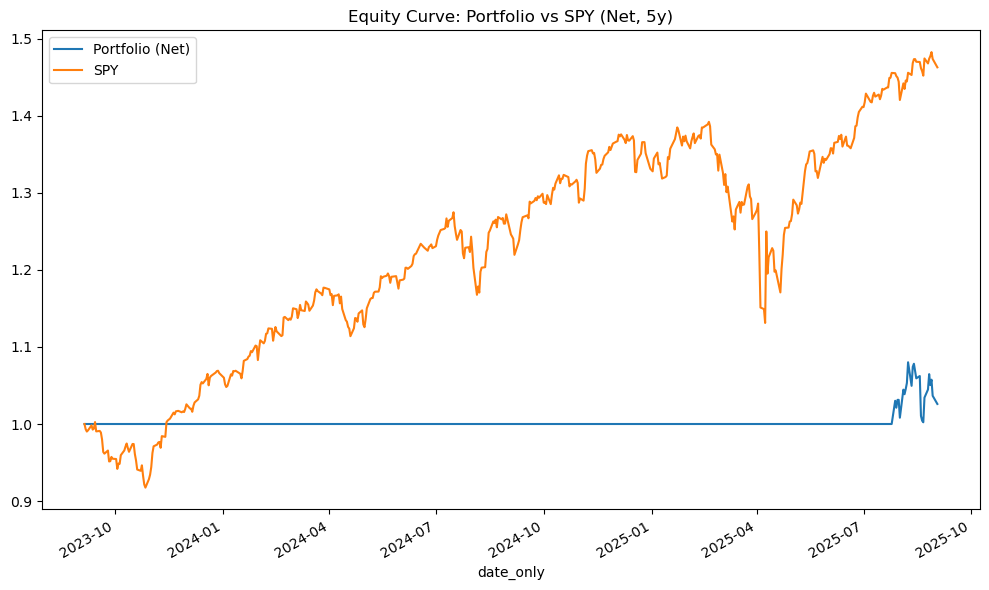

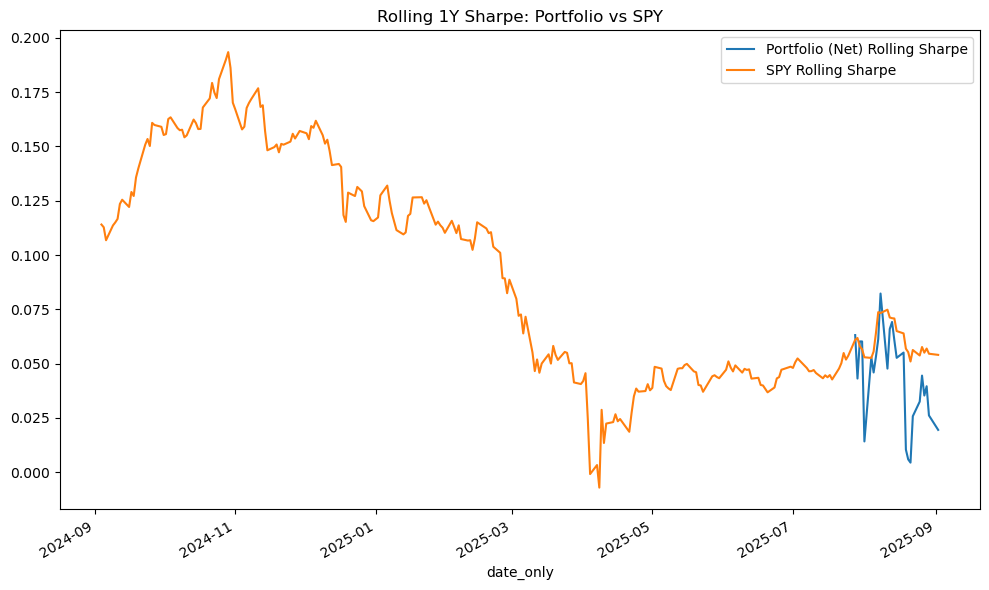

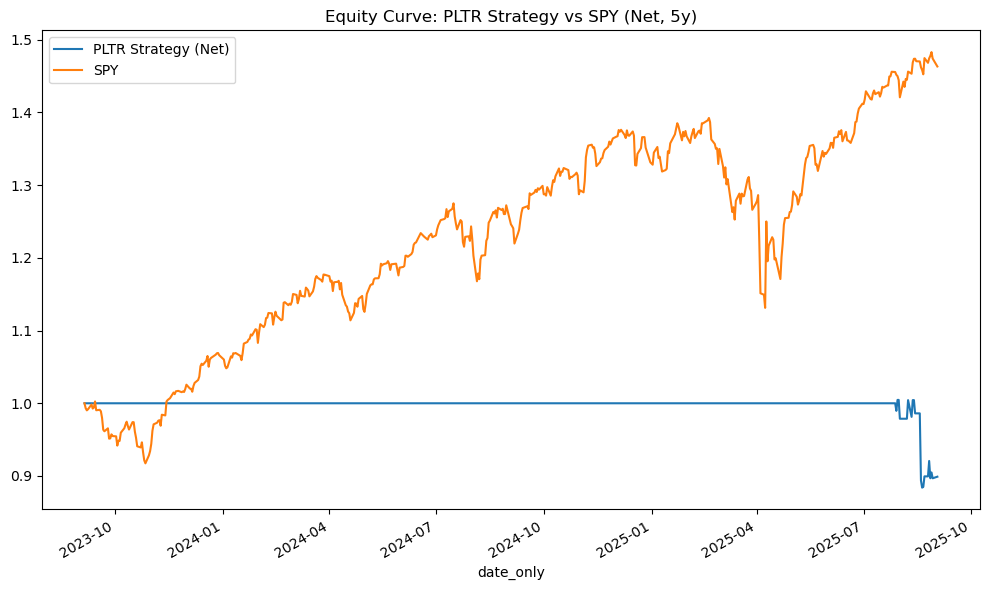

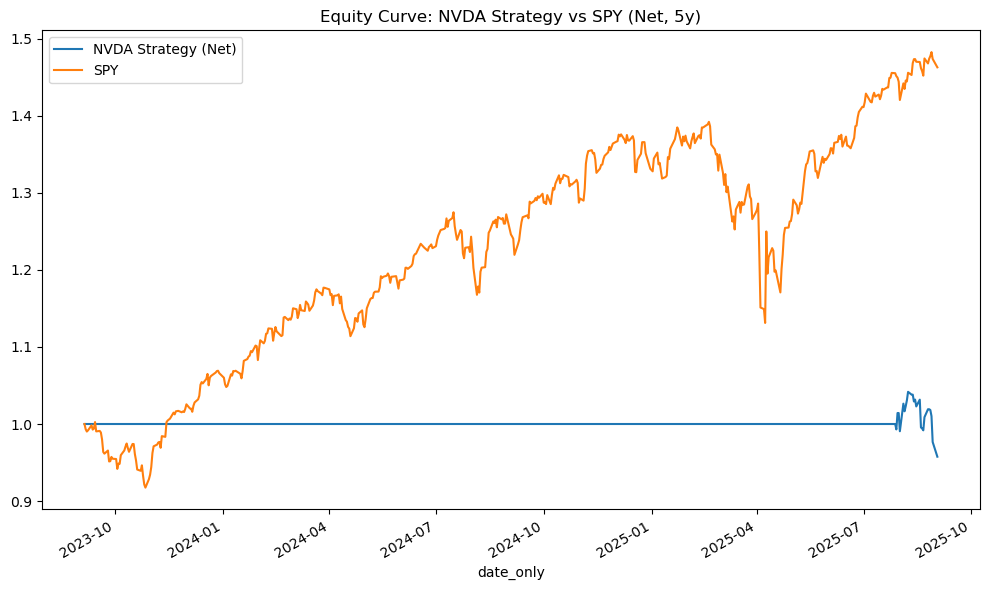

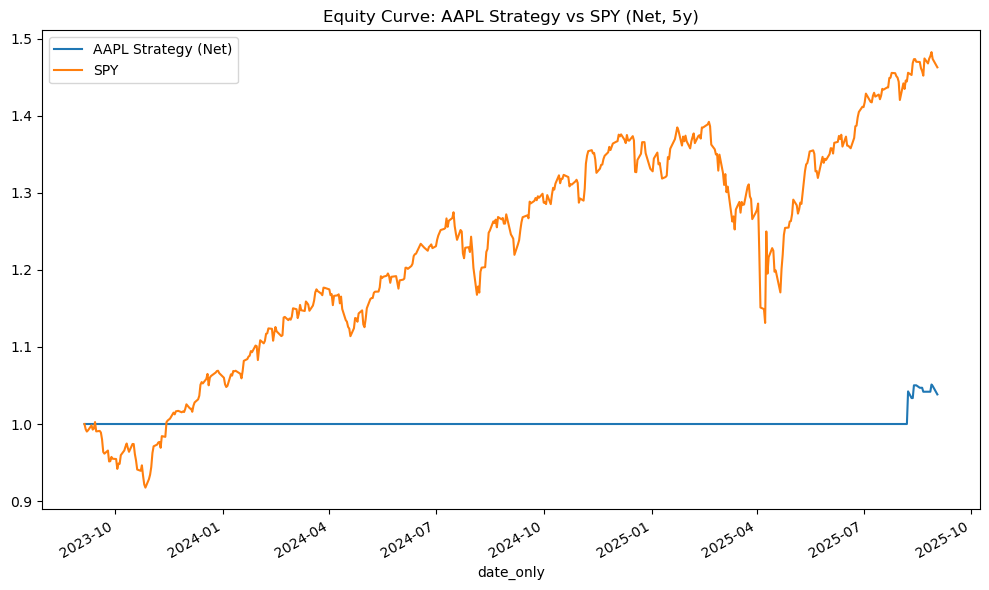

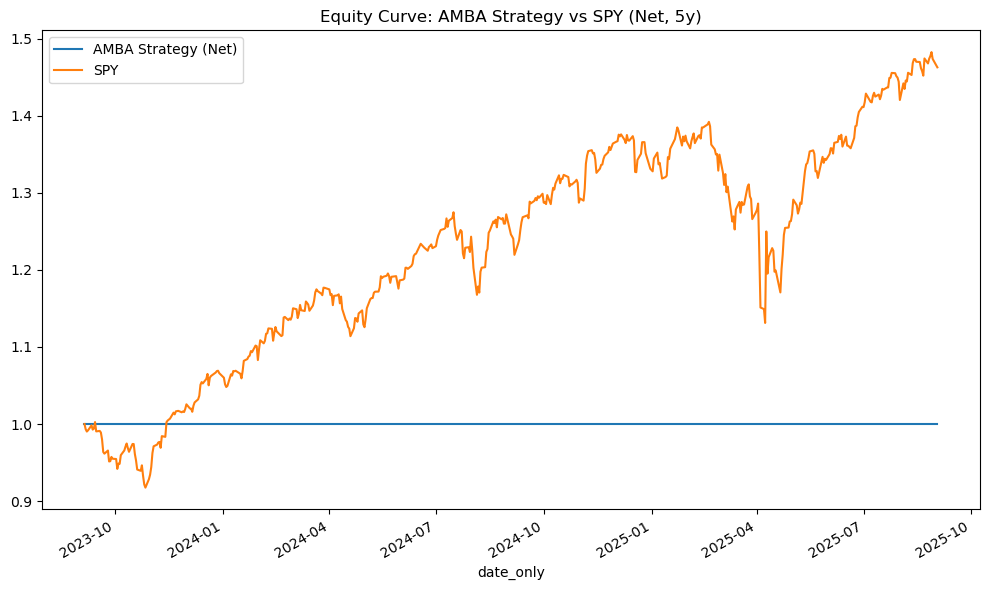

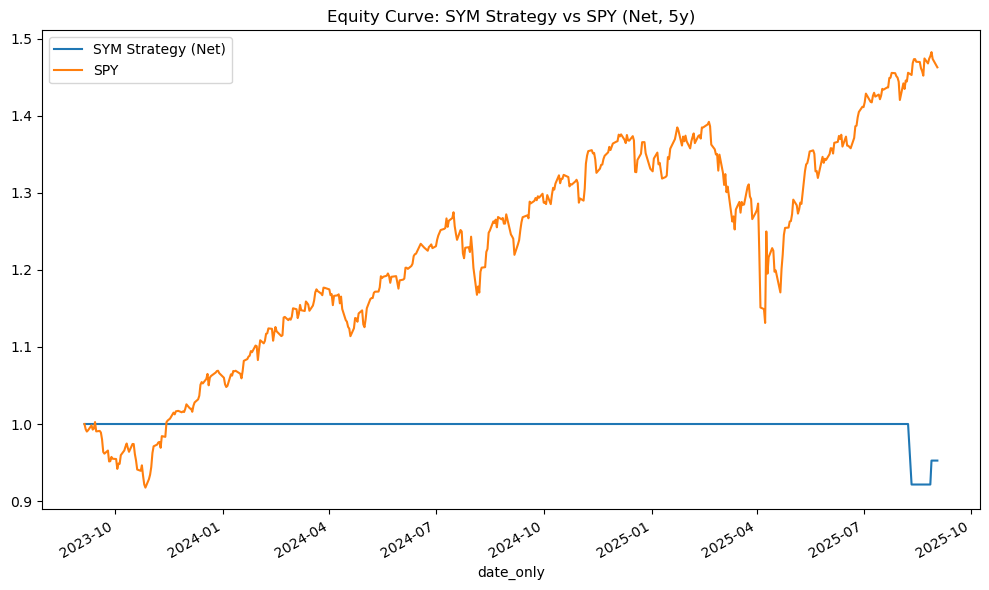

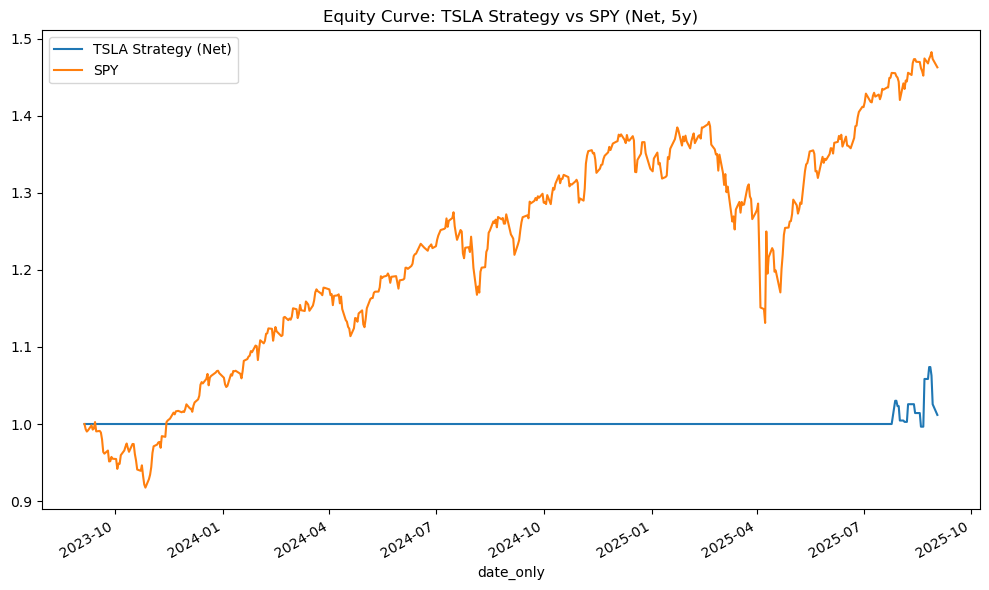

Backtest complete. CSV outputs written:
- backtest_metrics_summary.csv
- backtest_portfolio_daily_returns.csv
- backtest_spy_daily_returns.csv


In [57]:
# -----------------------------
# 8) Plots: Equity curves & Rolling Sharpe
# -----------------------------
# Equity curve: Portfolio vs SPY
plt.figure(figsize=(10,6))
(1 + net_ret).cumprod().plot(label="Portfolio (Net)")
(1 + spy_rets).cumprod().plot(label="SPY")
plt.title("Equity Curve: Portfolio vs SPY (Net, 5y)")
plt.legend()
plt.tight_layout()
plt.show()

# Rolling 1Y Sharpe (approx using 252 trading days)
rolling_sharpe_port = net_ret.rolling(TRADING_DAYS).mean() / net_ret.rolling(TRADING_DAYS).std(ddof=0)
rolling_sharpe_spy = spy_rets.rolling(TRADING_DAYS).mean() / spy_rets.rolling(TRADING_DAYS).std(ddof=0)

plt.figure(figsize=(10,6))
rolling_sharpe_port.plot(label="Portfolio (Net) Rolling Sharpe")
rolling_sharpe_spy.plot(label="SPY Rolling Sharpe")
plt.title("Rolling 1Y Sharpe: Portfolio vs SPY")
plt.legend()
plt.tight_layout()
plt.show()

# Per-stock equity curves vs SPY (net of costs)
for t, d in per_stock_results.items():
    plt.figure(figsize=(10,6))
    (1 + d["net"]).cumprod().plot(label=f"{t} Strategy (Net)")
    (1 + spy_rets).cumprod().plot(label="SPY")
    plt.title(f"Equity Curve: {t} Strategy vs SPY (Net, 5y)")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Backtest complete. CSV outputs written:\n"
      "- backtest_metrics_summary.csv\n"
      "- backtest_portfolio_daily_returns.csv\n"
      "- backtest_spy_daily_returns.csv")